### Emma Klemets, 260775167   
Work done to develop the mass model for #4.

In [1]:
import numpy as np
import matplotlib

import matplotlib.pyplot as plt
import time
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D

from particleClass import *

### Part 4: 
*In cosmology, we start the universe with a scale-invariant power spectrum, so mass fluctuations are proportional to $k^{−3}$. Start with the particles on a grid, but with masses derived from a realization of $k^{−3}$ and use periodic boundary conditions (although not strictly necessary, you may with to start with your particles in the center of grid cells rather than at the corners). How does your universe look now?*

Trying to follow form https://garrettgoon.com/gaussian-fields/.
I have ended up with two version, one I wrote myself that I don't think is quite working properly, and another using the FyeldGenerator python package.

### First working in 2D

In [300]:
from FyeldGenerator import generate_field

# https://github.com/cphyc/FyeldGenerator

In [301]:
# Helper that generates power-law power spectrum, can I just use this?
def Pkgen(n):
    def Pk(k):
        return np.power(k, -n)

    return Pk

# Draw samples from a normal distribution
def distrib(shape):
    a = np.random.normal(loc=0, scale=1, size=shape)
    b = np.random.normal(loc=0, scale=1, size=shape)
    return a + 1j * b

def gen_field(gridSize, dx, dim):
    if dim==2:
        shape = (gridSize[0], gridSize[1])
    else:
        shape = (gridSize[0], gridSize[1], gridSize[2])

    x_arr = np.arange(0, gridSize[0], dx)

    field = generate_field(distrib, Pkgen(3), shape)
    return field

In [302]:
def P_k_dist(gridSize, dx, n, dim, cosm="mine"):

    x = np.arange(0, gridSize[0], dx)
    
    #using my attempt at getting the density k^-3 field, it looks decent in 2d, but not 3d
    if cosm=="mine":
        N = gridSize[0]
        
        #0-N/2, -N/2 - (-1)
        N = gridSize[0] + 1 #only going to work with even grid sizes rip
        a = np.arange(0, N/2, dx)
        b = np.arange(-N/2+1, -1, dx)

        k_grid = np.concatenate((a, b)) * 2 * np.pi / N

        k_moreD = []

        for i in range(0, len(k_grid)):
            kk = []
            for j in range(0, len(k_grid)):
                if dim==3:
                    k3 = []
                    for k in range(0, len(k_grid)):
                        k3.append(np.sqrt(k_grid[i]**2 + k_grid[j]**2))
                    kk.append(k3)
                else:
                    kk.append(np.sqrt(k_grid[i]**2 + k_grid[j]**2))
            k_moreD.append(kk)

        k_moreD = np.array(k_moreD)

        #actually do the power law
        pk = 1/np.abs(k_moreD**3)

        nans = np.argwhere(np.isinf(pk))

        for i in nans:
            if dim==2:
                pk[i[0]][i[1]] = 0.0
            else:
                pk[i[0]][i[1]][i[2]] = 0.0

        pk_sq = np.sqrt(pk)

        whitenoise = np.fft.fft(np.random.normal(0,1, (gridSize/dx).astype(int) ))
        pk_noise = pk_sq*whitenoise

        kgrid_inv = np.fft.irfftn(pk_noise, s=pk_noise.shape)
        
    #using the FyeldGenerator for better results in 3D
    else:
        kgrid_inv = gen_field(gridSize, dx, dim)
    
    #rescaling it from a density to a probability
    #I think this is probably wrong, but it keeps the structure and I don't know what else to do
    minP = np.min(kgrid_inv)
    maxP = np.max(kgrid_inv)

    q_s = kgrid_inv/(maxP - minP)

    m = np.min(q_s)
    q_s_up = q_s - m

    return q_s_up, x

In [303]:
def getMass(n, x, P, dt, max_m, dim):
    m = np.zeros(n)
    
    for i in range(n):
        #need to figure out which cell each particle is in
        #then pick out the prob in that cell to use here

        cell_n = np.floor(x[i]/(dt)).astype('int64') 

        if dim==2:
            P_val = P[cell_n[0]][cell_n[1]]
        else:
            P_val = P[cell_n[0]][cell_n[1]][cell_n[2]]
        
        #what kind of distribution are we then using?
        #we need mass to be positive, just use a normal distribution for now        
        mass = np.random.uniform(0, P_val,1)*max_m
        m[i] = mass
        
    return m 


#### 2D with my algo

In [304]:
n=100000
d=2
gridSize = np.array([100, 100])#, 15]
dt_t = 1.

#get the prob distribution
Prob_d, x_arr = P_k_dist(gridSize, dt_t, n, d, cosm="mine")

#single particle at rest
x=np.random.uniform(1.0, gridSize[0]-1.0,(n,d)) #need to place closer to center
v=np.random.randn(n,d)*0

<ipython-input-302-ebd02135ee20>:33: RuntimeWarning: divide by zero encountered in true_divide
  pk = 1/np.abs(k_moreD**3)


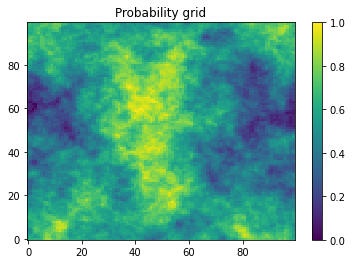

In [305]:
fig, ax = plt.subplots() #looks a little better but it's very smooth

c = ax.pcolormesh(x_arr, x_arr, Prob_d, shading='auto')
ax.set_title('Probability grid')

fig.colorbar(c, ax=ax)
plt.show()

In [306]:
max_m = 1.0

m = getMass(n, x, Prob_d, dt_t, max_m, d)

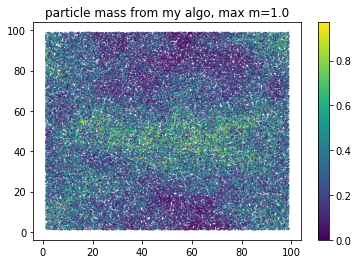

In [307]:
fig, ax = plt.subplots()
plt.title("particle mass from my algo, max m=1.0")
im = ax.scatter(x[:,0], x[:,1], c=m, s=0.3, marker=".")
fig.colorbar(im, ax=ax)
plt.show()

#### 2D with FyeldGenerator

In [308]:
n=100000
d=2
gridSize = np.array([100, 100])#, 15]
dt_t = 1.

#get the prob distribution
Prob_d, x_arr = P_k_dist(gridSize, dt_t, n, d, cosm="other")

x=np.random.uniform(1.0, gridSize[0]-1.0,(n,d)) #need to place closer to center
v=np.random.randn(n,d)*0

<ipython-input-301-6e7d1ab3077b>:4: RuntimeWarning: divide by zero encountered in power
  return np.power(k, -n)


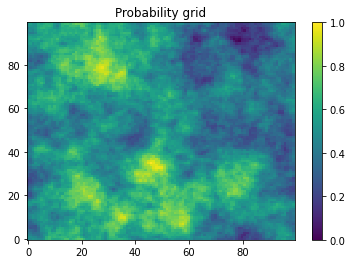

In [309]:
fig, ax = plt.subplots() #looks a little better but it's very smooth

c = ax.pcolormesh(x_arr, x_arr, Prob_d, shading='auto')
ax.set_title('Probability grid')

fig.colorbar(c, ax=ax)
plt.show()


In [310]:
max_m = 1.0

m = getMass(n, x, Prob_d, dt_t, max_m, d)

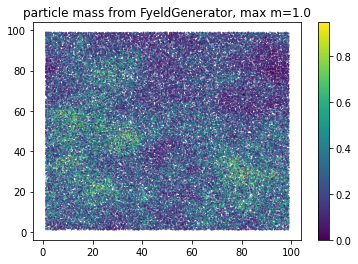

In [311]:
fig, ax = plt.subplots()
plt.title("particle mass from FyeldGenerator, max m=1.0")
im = ax.scatter(x[:,0], x[:,1], c=m, s=0.3, marker=".")
fig.colorbar(im, ax=ax)
plt.show()

### Now in 3D

In [297]:
n=100000
d=3
gridSize = np.array([100, 100, 100])#, 15]
dt_t = 1.0

#get the prob distribution
Prob_d, x_arr = P_k_dist(gridSize, dt_t, n, d, cosm="mine")

#single particle at rest
x=np.random.uniform(1.0, gridSize[0]-1.0,(n,d)) #need to place closer to center
v=np.random.randn(n,d)*0

max_m = 1.0

m = getMass(n, x, Prob_d, dt_t, max_m, d)

<ipython-input-210-ebd02135ee20>:33: RuntimeWarning: divide by zero encountered in true_divide
  pk = 1/np.abs(k_moreD**3)


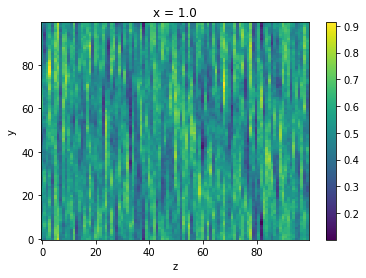

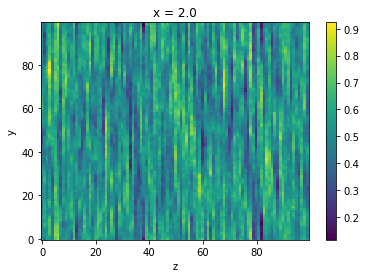

In [298]:
fig, ax = plt.subplots() #not good with mine in 3d, weird strips

xx=np.arange(0, gridSize[0], dt_t)
yy,zz=np.meshgrid(xx,xx)

for i in range(1, 3):
    plt.pcolor(yy, zz, Prob_d[i],  shading='auto')
#     plt.pcolor(yy,zz, g[i],  shading='auto')
    
    plt.title("x = {}".format(i*dt_t))
    plt.xlabel("z")
    plt.ylabel("y")
    plt.colorbar()
    plt.show()

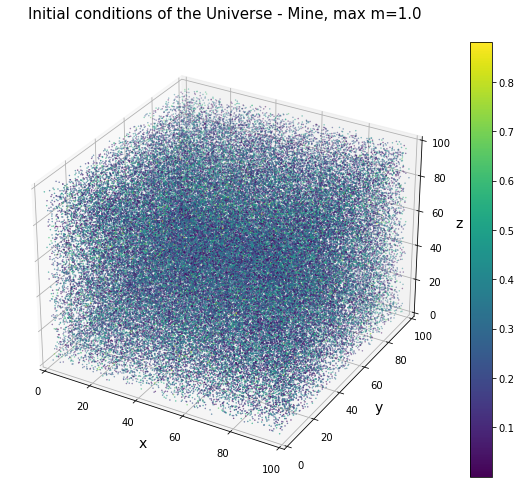

In [299]:
fig = plt.figure(figsize=(10,8))
ax=fig.add_subplot(111,projection="3d")
# ax = Axes3D(fig)
ax.set_xlabel("x",fontsize=14)
ax.set_ylabel("y",fontsize=14)
ax.set_zlabel("z",fontsize=14)

ax.set_xlim3d(0, gridSize[0])
ax.set_ylim3d(0,gridSize[1])
ax.set_zlim3d(0,gridSize[2])

ax.set_title("Initial conditions of the Universe - Mine, max m=1.0\n",fontsize=15)
scatt = ax.scatter(x[:,0], x[:,1], x[:,2], c=m, marker=".", s=.9)

fig.colorbar(scatt, ax=ax)
plt.show()

#### Now in 3D with FyeldGenerator

In [273]:
n=100000
d=3
gridSize = np.array([100, 100, 100])#, 15]
dt_t = 1.0

#get the prob distribution
Prob_d, x_arr = P_k_dist(gridSize, dt_t, n, d, cosm="other")

#single particle at rest
x=np.random.uniform(1.0, gridSize[0]-1.0,(n,d)) #need to place closer to center
v=np.random.randn(n,d)*0

max_m = 10.0

m = getMass(n, x, Prob_d, dt_t, max_m, d)

print(m)

<ipython-input-196-6e7d1ab3077b>:4: RuntimeWarning: divide by zero encountered in power
  return np.power(k, -n)


[0.77085148 0.70418544 0.45894884 ... 2.76903828 0.25332817 1.21063802]


In [279]:
l=0
for i in m:
    if i > 7:
        l +=1
        
print(l)

39


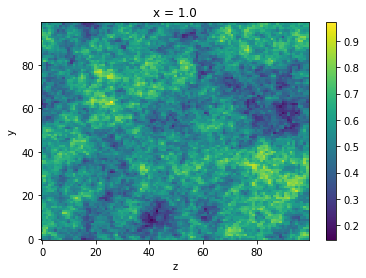

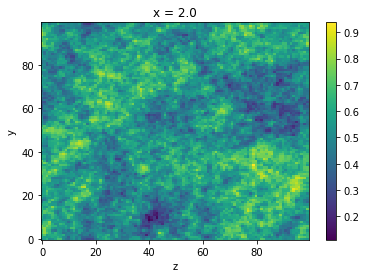

In [271]:
fig, ax = plt.subplots() #not good with mine in 3d, weird strips

xx=np.arange(0, gridSize[0], dt_t)
yy,zz=np.meshgrid(xx,xx)

for i in range(1, 3):
    plt.pcolor(yy, zz, Prob_d[i],  shading='auto')
#     plt.pcolor(yy,zz, g[i],  shading='auto')
    
    plt.title("x = {}".format(i*dt_t))
    plt.xlabel("z")
    plt.ylabel("y")
    plt.colorbar()
    plt.show()

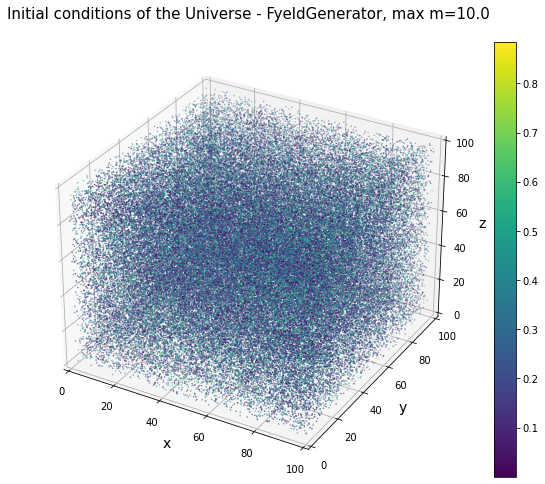

In [296]:
fig = plt.figure(figsize=(10,8))
ax=fig.add_subplot(111,projection="3d")
ax.set_xlabel("x",fontsize=14)
ax.set_ylabel("y",fontsize=14)
ax.set_zlabel("z",fontsize=14)

ax.set_xlim3d(0, gridSize[0])
ax.set_ylim3d(0,gridSize[1])
ax.set_zlim3d(0,gridSize[2])

ax.set_title("Initial conditions of the Universe - FyeldGenerator, max m=10.0\n",fontsize=15)
scatt = ax.scatter(x[:,0], x[:,1], x[:,2], c=m, marker=".", s=.8)

fig.colorbar(scatt, ax=ax)
plt.show()